In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time

In [66]:
from schmutz import trappist1, transit_duration

In [15]:
from rms import Star, Planet, Spot, STSP

In [81]:
spot_contrast = 0.7
rotation_period = 3.3 * u.day
planet = trappist1('b')
planet.lam = 0
planet.per_rot = rotation_period.value
planet.b = np.cos(np.radians(planet.inc)) * planet.a
planet.duration = transit_duration(planet)

star = Star(u=[0.161, 0.208], rotation_period=rotation_period, 
            inc_stellar=90, spot_contrast=spot_contrast, 
            rho_s=51.1, planet=planet)

In [92]:
spots = [Spot(0*u.deg, 0*u.deg, 0.5)]
tiny_polar_spot = [Spot(89*u.deg, 0*u.deg, 0.00001)]

times = Time(np.arange(planet.t0 - 0.02, planet.t0 + 0.02, 1/60/60/24), format='jd')

with STSP(times, star, spots) as stsp: 
    lc = stsp.generate_lightcurve(normalize_oot=True)
    
with STSP(times, star, tiny_polar_spot) as stsp: 
    lc_nospots = stsp.generate_lightcurve(normalize_oot=True)

[Text(0,0.5,'Residuals'), Text(0.5,0,'Time')]

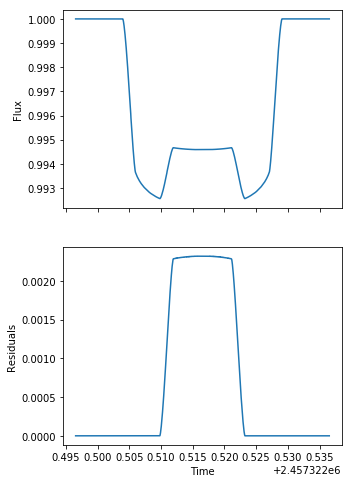

In [94]:
fig, ax = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
ax[0].plot(lc.times.jd, lc.fluxes)
ax[0].set(ylabel='Flux')
ax[1].plot(lc.times.jd, lc.fluxes - lc_nospots.fluxes)
ax[1].set(xlabel='Time', ylabel='Residuals')